In [25]:
import numpy as np 
import pandas as pd 

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import tensorflow as tf
from tensorflow import keras

from scipy import stats
import scipy.optimize as optimize

import datetime
import yfinance as yf

import glob
import random

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
import warnings
warnings.filterwarnings(action='ignore')

from statsmodels.tsa.arima_model import ARIMA

from itertools import product


In [26]:
def scrap(data):
    result = yf.download(data,'2009-06-03','2019-11-08')['Adj Close']
    return result 

In [27]:
org_data = pd.read_csv('C:/Users/Renzo/Desktop/Finanzas/GARCH/options/options_KR.csv')

In [28]:
CBOE_Volatility = pd.read_csv("CBOE Volatility Index Historical Data.csv")
HSI_Volatility  = pd.read_csv("HSI Volatility Historical Data.csv")
Nikkei_Volatility = pd.read_csv("Nikkei Volatility Historical Data.csv")

CBOE_Volatility = CBOE_Volatility.loc[:,['Date','Price']]
HSI_Volatility = HSI_Volatility.loc[:,['Date','Price']]
Nikkei_Volatility = Nikkei_Volatility.loc[:,['Date','Price']]
Nikkei_Volatility = Nikkei_Volatility.rename(columns={'Price': 'Nikkei_vol'})
CBOE_Volatility = CBOE_Volatility.rename(columns={'Price': 'CBOE_vol'})
HSI_Volatility = HSI_Volatility.rename(columns={'Price': 'HSI_vol'})
merged_df = pd.merge(CBOE_Volatility, HSI_Volatility, on='Date')
merged_df = pd.merge(merged_df, Nikkei_Volatility, on='Date')
merged_df['Date'] = pd.to_datetime(merged_df['Date']).dt.strftime('%Y-%m-%d')
merged_df
# Nikkei_Volatility

,Date,CBOE_vol,HSI_vol,Nikkei_vol
0,2019-11-07,12.73,14.74,14.33
1,2019-11-06,12.62,15.19,15.18
2,2019-11-05,13.10,15.52,14.67
3,2019-11-01,12.30,15.36,14.27
4,2019-10-31,13.22,15.18,14.25
...,...,...,...,...
2358,2009-06-08,29.77,39.57,30.79
2359,2009-06-05,29.62,38.96,30.28
2360,2009-06-04,30.18,40.38,32.48
2361,2009-06-03,31.02,40.30,31.79


In [29]:
return_org_data_y = org_data['KOSPI200'].shift(1)
return_org_data = ((org_data['KOSPI200'] - return_org_data_y) / return_org_data_y).dropna()
return_org_data

1      -0.002377
2      -0.000887
3      -0.025290
4       0.011494
5      -0.000563
          ...   
2575    0.001125
2576    0.009463
2577    0.014761
2578    0.006512
2579    0.000492
Name: KOSPI200, Length: 2579, dtype: float64

In [30]:
def transform_data(data):
    data['Date'] = pd.to_datetime(data['Date']).dt.strftime('%Y-%m-%d')



In [31]:
pivot = ['Date','VKOSPI','Day_till_expiration','Day_of_a_week']

# Save the original data
full_data = org_data.copy()

# Shift the pivot data
full_data[pivot] = full_data[pivot].shift(periods=-1)

# Drop the last row
full_data = full_data.drop(full_data.index[-1])


In [32]:
def correspond_foreign_vol(date, data):
    """
    Find the 'Price' of the date that is most recent to the given 'Date' in the 'data'
    """
    
    while date >= data['Date'].min():  # Stop the loop when date is earlier than the minimum date in data
        result_series = data['Price'].loc[data['Date'] == date]  # Find the 'Price' in the data that matches with the 'date'
        
        if not result_series.empty:  # If not empty (which means there is a row that matches with the 'date')
            result_series = result_series.reset_index()  # Reset index
            result_value = result_series['Price'][0]  # Get the value
            return result_value
        
        date = date - pd.Timedelta(days=1)  # Go back one day

    # If no match found, return a default value or handle the case as needed
    return None  # You can change this to an appropriate default value or error handling




def garch_forward(return_rate,variance,coefficients):
    
    # coefficients
    alpha,beta,omega = coefficients
    return omega + alpha*return_rate + beta*variance


In [33]:
initial_vkospi = full_data['VKOSPI'][1] 
initial_variance = initial_vkospi*initial_vkospi/2520000 
initial_variance

0.00042069587301587304

In [34]:
order_book_train_files = glob.glob('book_train/*')
stock_ids = [stock.split('=')[1] for stock in order_book_train_files]
df_order_book_train_files = pd.DataFrame({'stock_id': stock_ids,'stock_path': order_book_train_files})
df_order_book_train_files.head()

,stock_id,stock_path
0,0,book_train\stock_id=0
1,1,book_train\stock_id=1
2,10,book_train\stock_id=10
3,100,book_train\stock_id=100
4,101,book_train\stock_id=101


In [35]:
def calculate_wap(df):
    a = df['bid_price1'] * df['ask_size1']
    b = df['ask_price1'] * df['bid_size1']
    c = df['bid_size1'] + df['ask_size1']
    return (a + b) / c

def log_return(list_stock_prices):
    return np.log(list_stock_prices).diff()

In [43]:
def abs_log_returns_topn(list_file, n_top):
    '''Returns log returns for top n stocks from shuffled stock list'''
    df_list = []
    for stock_file in list_file[:n_top]:
        df_book_data = pd.read_parquet(stock_file)
        df_book_data['wap'] = calculate_wap(df_book_data) 
        df_book_data['log_return'] = df_book_data.groupby(['time_id'])['wap'].apply(log_return)
        df_book_data = df_book_data[~df_book_data['log_return'].isnull()]
        df_book_data['log_return'] = df_book_data['log_return'].apply(abs)
        df_book_data['stock_id'] = int(stock_file.split('=')[1])
        df_list.append(df_book_data)
    df = pd.concat(df_list, ignore_index=True)
    return df
# Randomly shuffle the stocks
random.shuffle(order_book_train_files)

# Get log returns for 5 stocks sample
df_log_returns = abs_log_returns_topn(order_book_train_files, 5)

selected_stocks = df_log_returns['stock_id'].unique()
print('Stock Ids:', ', '.join(str(s) for s in selected_stocks))

df_log_returns['stock_id'].value_counts()

Stock Ids: 37, 41, 44, 80, 38


44    2158851
41    2140327
80    1429737
38    1072488
37     772462
Name: stock_id, dtype: int64

ACF-PACF PLOTS

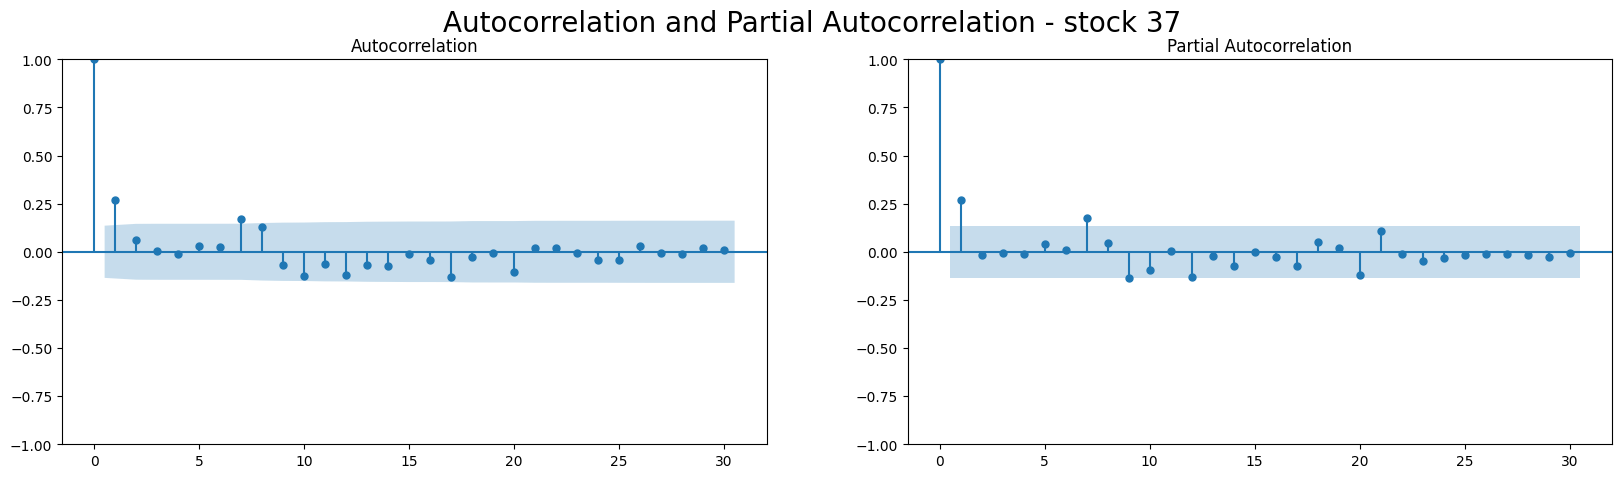

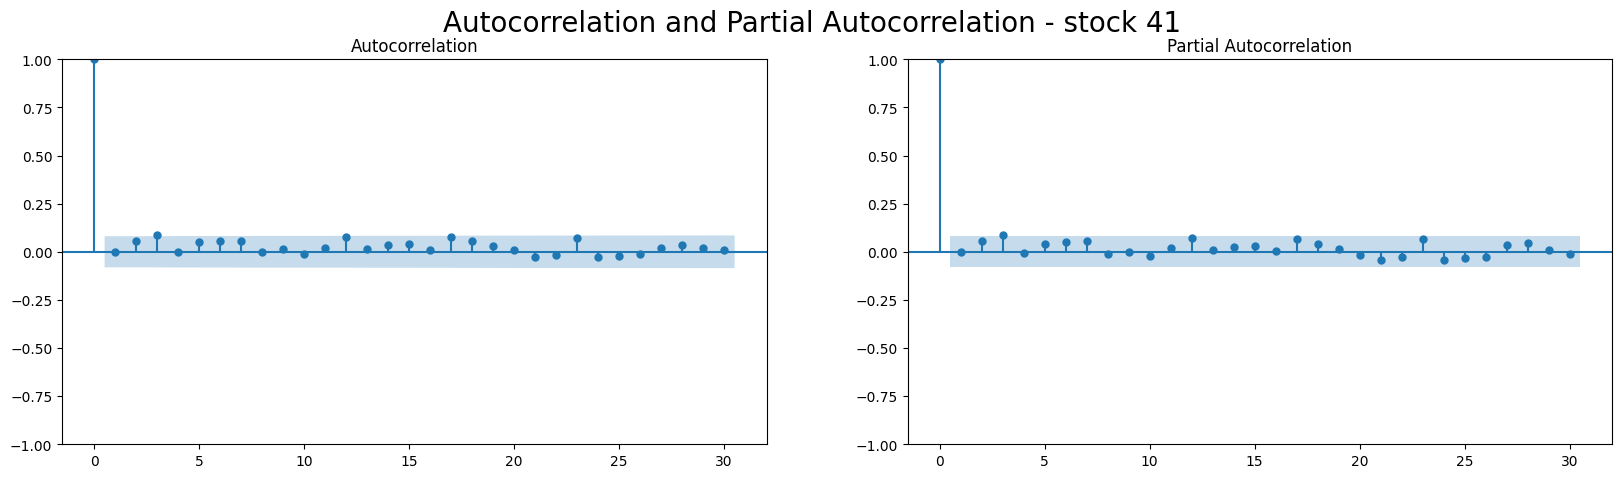

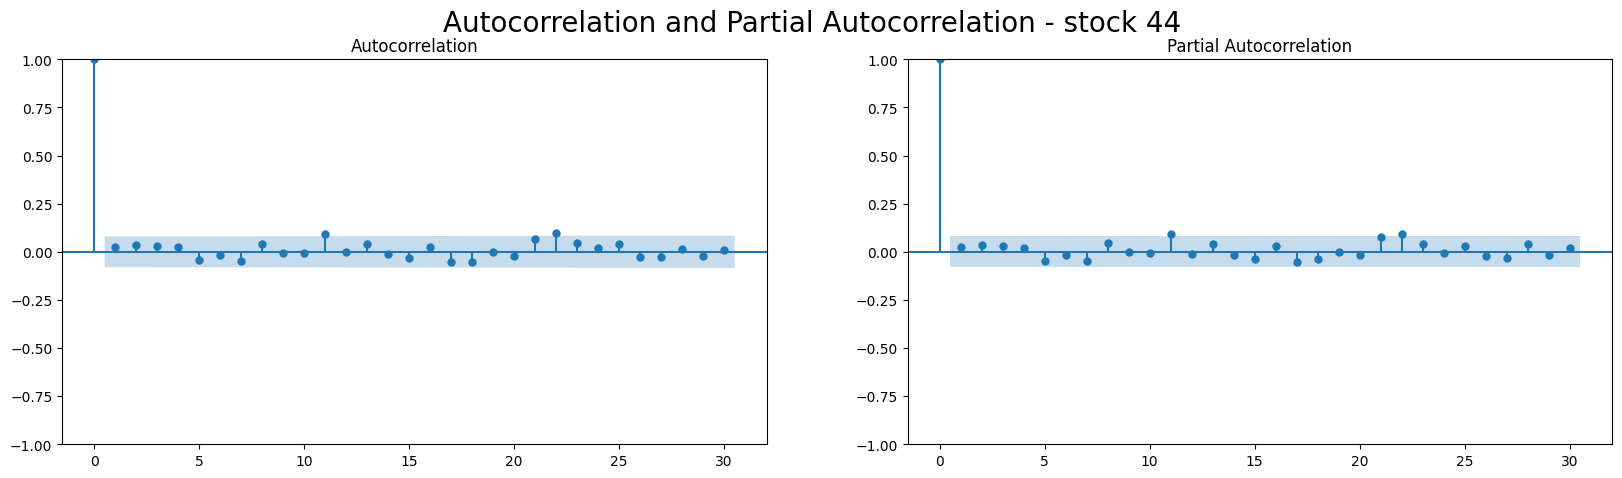

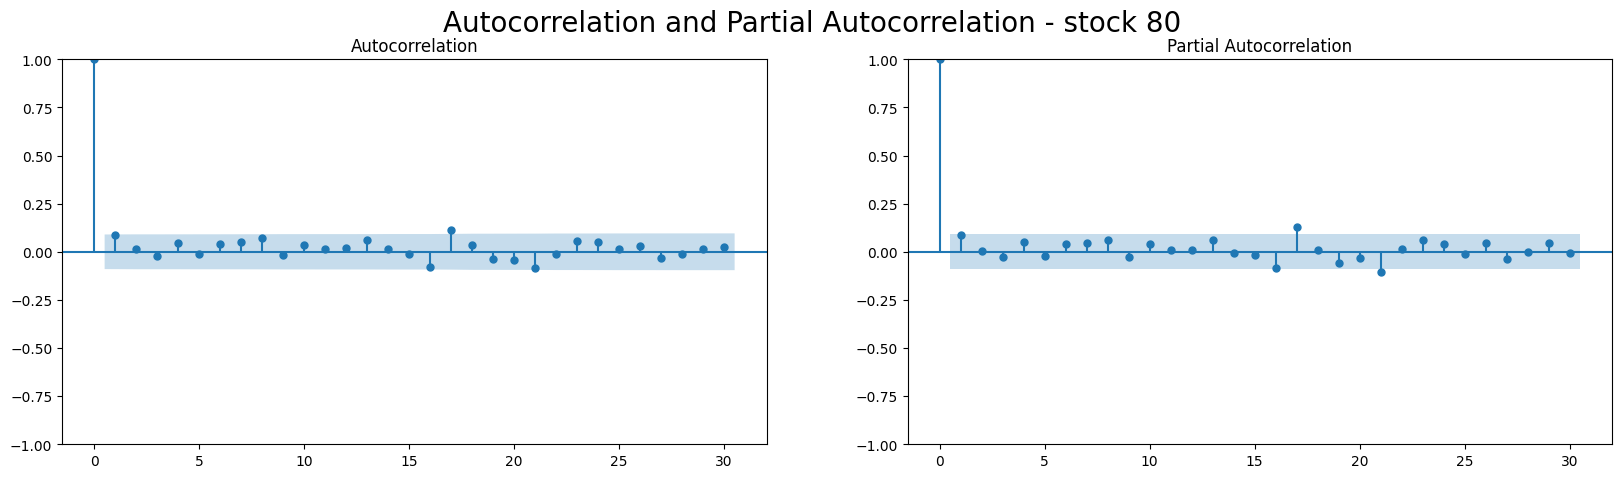

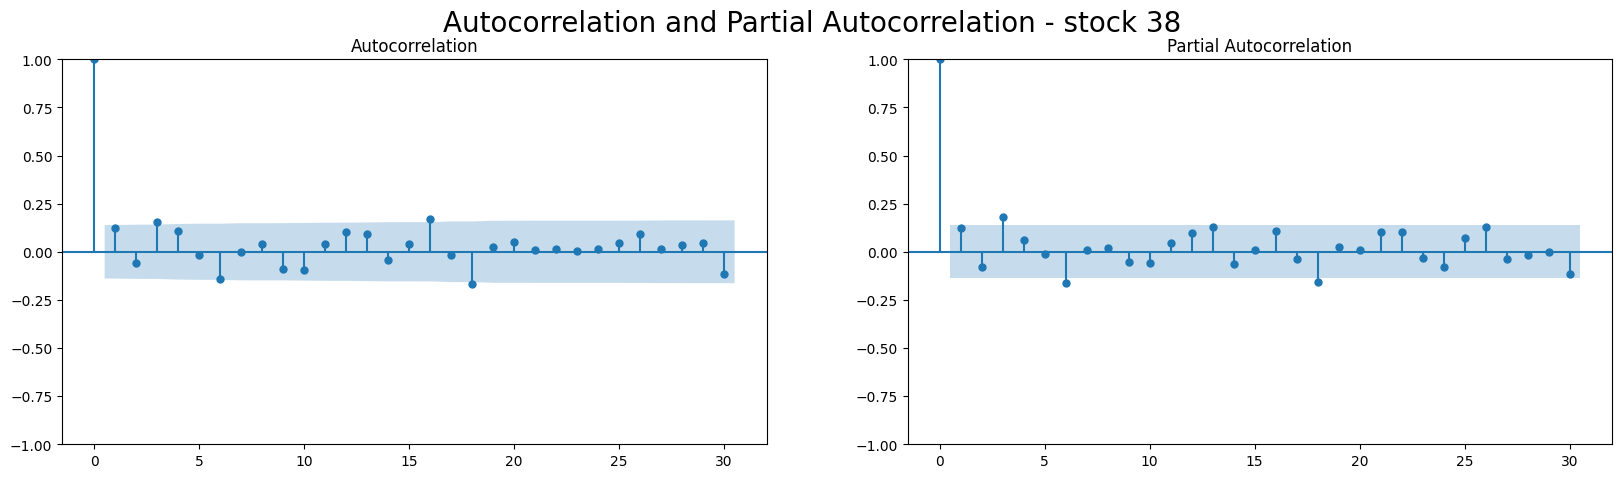

In [47]:
def plot_auto_correlation(series, lags=30, stock=''):
    plt.rcParams["figure.figsize"] = 20, 5
    fig,axes = plt.subplots(1,2)
    acf = plot_acf(series, lags=lags, ax = axes[0])
    pacf = plot_pacf(series, lags=lags, ax = axes[1])
    acf.suptitle(f'Autocorrelation and Partial Autocorrelation - stock {stock}', fontsize=20)
    plt.show()

for stock_id in selected_stocks:
    df_log_returns_stock = df_log_returns[df_log_returns['stock_id'] == stock_id]
    random_time_id = random.choice(df_log_returns_stock['time_id'].unique())
    df_time_slice = df_log_returns_stock[df_log_returns_stock['time_id'] == random_time_id]
    plot_auto_correlation(df_time_slice['log_return'], stock=stock_id)
        

In [45]:
arima_order = []
for stock_id in selected_stocks:
    orders = []
    for order_seq in product((2, 1, 0), repeat=3):
        if order_seq == (0, 0, 0):     #ARIMA(0,0,0) model is white noise 
            continue
        try:
            df_log_returns_stock = df_log_returns[df_log_returns['stock_id'] == stock_id]
            # Slicing random time period to train ARIMA model
            random_time_id = random.choice(df_log_returns_stock['time_id'].unique())
            df_time_slice = df_log_returns_stock[df_log_returns_stock['time_id'] == random_time_id]
            arima_model = ARIMA(df_time_slice['log_return'], order = order_seq)
            results_ARIMA = arima_model.fit(disp=-1)
            orders.append(order_seq)
        except:
            pass
    if len(orders) == 0:
        orders.append((0, 0, 0))
    min_order = min(orders, key=lambda x: (x[0], x[1], x[2]))
    arima_order.append([stock_id, min_order])
df_arima_order_min = pd.DataFrame(arima_order, columns=['stock_id', 'order'])



In [46]:
df_arima_order_min

,stock_id,order
0,37,"(0, 0, 0)"
1,41,"(0, 0, 0)"
2,44,"(0, 0, 0)"
3,80,"(0, 0, 0)"
4,38,"(0, 0, 0)"


In [39]:
df_arima_order_min = pd.merge(df_arima_order.groupby('stock_id')['aic'].min().reset_index(),
                          df_arima_order, 
                          how='left', 
                          on=['stock_id','aic'])
df_arima_order_min

,stock_id,order,aic
